# COMS 4732: Advanced Computer Vision Homework 3 


## Overview

In this assignment, we'll build a simple convolutional neural network in PyTorch and Train it to recognize natural objects using the CIFAR-10 dataset. Training a classifier on the CIFAR-10 dataset can be regarded as the hello world of image recognition. The structure of this assignment is:

    1. Introduction
    2. Setting up the Environment
    3. Preparing the Data
    4. Building the Network
    5. Training the Model and Evaluating the Performance
    6. Understand the Deep Neural Networks

(The full content can be better viewed in jupyter notebook).

### Submission Instructions

- Please submit the notebook (ipynb and pdf) including the output of all cells. Please note that you should export your completed notebook as a PDF (CV2_HW3_UNI.pdf) and upload it to GradeScope.
- Then, please submit the executable completed notebook (CV2_HW3_UNI.ipynb) to Cousework.
- For both files, 1) remember to replace UNI with your own uni; 2) the completed notebook should show your code, as well as the log and image.

## Introduction

Object Recognition typically aims to train a model to recognize, identify, and locate the objects in the images with a given degree of confidence. Object recognition is also called image recognition in many other kinds of literature, which is strictly related to computer vision, which we define as the art and science of making computers understand images.

Deep learning has contributed quite a lot to the development of object recognition algorithms and has achieved many surprising results on many benchmark datasets, such as ImageNet, MS COCO, LVIS. Also, different architectures are proposed to improve the accuracy and efficiency of the learned models. As a brief introduction, we first go through some basic concepts in object recognition and give the following tasks:

1. Classification.
2. Detection.
3. Segmentation.

In this assignment, we <ins> only dive into the image classification task </ins> and we start with a small model on a toy dataset. We do encourage you to explore the other tasks. Here are a few interesting references:
1. https://towardsdatascience.com/creating-your-own-object-detector-ad69dda69c85
2. https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef
3. https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/
4. https://blog.paperspace.com/mask-r-cnn-in-tensorflow-2-0/
5. https://www.analyticsvidhya.com/blog/2021/05/an-introduction-to-few-shot-learning/

### Classification
Classification is an important task in Object recognition and aims to identify what is in the image and with what level of confidence.
The general pipeline of this task is straightforward. It starts with the definition of the ontology, i.e. the class of objects to detect. Then, the classification task identifies what is in the image (associated level of confidence) and picks up the class with the highest confidence. Usually, each test image used for classification has one dominant object in the image and we directly use the representation of the whole image for classification.

<div>
<img src="attachment:Classification.png" width="256"/>
</div>

For the example given above, the classification algorithm will only remember that there is a dog, ignoring all other classes. 
Similar to classification,  tagging also predicts confidence level for each class but aims to recognize multiple ones for a given image. For the example given below, it will try to return all the best classes corresponding to the image.

<div>
<img src="attachment:Tagging.png" width="300"/>
</div>

### Detection and segmentation
Once identified what is in the image, we want to locate the objects. There are two ways to do so: detection and segmentation.Detection outputs a rectangle, also called bounding box, where the objects are. It is a very robust technology, prone to minor errors and imprecisions.
<div>
<img src="attachment:Detection.png" width="300"/>
</div>

Segmentation identifies the objects for each pixel in the image, resulting in a very precise map. However, the accuracy of segmentation depends on an extensive and often time-consuming training of the neural network.

<div>
<img src="attachment:Segmentation.png" width="300"/>
</div>

Different from Classification, Detection and Segmentation ask the algorithm to return the location of the objects in the image. However, as no prior is given to predict the location, a set of potential locations/regions are enumerated. Then, the algorithm performs classification and localization prediction on each of the enumerated subregions. To note, the enumerated sub-regions differ from each other regarding the center location, aspect ratio, and size, while all of them are pre-defined by humans and all of the enumerated sub-regions can densely cover the full image. The location prediction is in effect predicting the offset w.r.t. each the sub-region. 

For object detection/segmentation, the two-stage and the one-stage frameworks have been dominating the related research area. Recently, the end-to-end object detector has been proposed to perform prediction in a unified manner (i.e., no pre-defined sub-region will be densely enumerated).

### Setting up the Environment

To learn a deep neural network, we need to first build proper environment and we use Pytorch.
For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

For this homework, you may need you Colab for your experiments. Under your columbia account, you can open the colab and then upload this jupyter notebook.
You need to use the Colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

You should be capable to directly run the following cells in most cases. However, in case you need, you can use the following code to install pytorch when you open the CoLab.
```
!pip install torch torchvision
!pip install Pillow==4.0.0
```

In [1]:
"""
Below are some input statements which basically imports numpy, torch, torchvision, matplotlib - This is a known standard and no need to memorise this
"""

import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import math
import os
import argparse
import tqdm

### Warm-Up for Pytorch

In [2]:
#Pytorch is very similar to numpy. Basically, any operation in numpy can be easily refered for pytorch operations 
# The following is a few examples. 

# Operations
y = torch.rand(2, 2)
x = torch.rand(2, 2)

# multiplication
z = x * y
z = torch.mul(x,y) #elementwise #must be broadcastable

#matrix multiplication
tensor1 = torch.randn(3, 4)
tensor2 = torch.randn(4, 3)
torch.matmul(tensor1, tensor2)

# NumPy conversion
x = torch.rand(2,2)
y = x.numpy()
print(type(y))

z1 = torch.from_numpy(y) #sharing the memory space with the numpy ndarray
z2 = torch.tensor(y) #a copy
print(type(z1))
print(type(z2))

# Pytorch attributes and functions for tensors
print(x.shape)
print(x.device)

# autograd

# requires grad equals true lets us compute gradients on the tenor
x = torch.tensor([2,3,5], dtype=float, requires_grad=True)
y =(5 * x**2).sum()

# When we finish our computation we can call .backward() and have all the gradients computed automatically
# The gradient for this tensor will be accumulated into .grad attribute
y.backward()
#print(z.grad) # dz/dz
# print(x.grad) # dz/dx

# autograd requires computational resources and can take time.
# disable autograd for model eval by writing your evaluation code in 
# As such, with torch.no_grad() is usually used in evaluation part

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([2, 2])
cpu


For repeatable experiments, we are recommended to set random seeds for anything using random number generation - this means numpy and random as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled by setting torch.backends.cudnn.enabled = False.

In [3]:
experiment_name = 'debug'  #Provide name to model experiment
model_name = 'basic' # Choose between [basic, alexnet]
batch_size = 5  #You may not need to change this but incase you do

torch.manual_seed(42)

## Preparing the Data

We provide the data-loading functions and a few helper functions below. 

To learn a deep learning algorithm, we need to prepare the data and this is where TorchVision comes into play. Usually, we have a training dataset and a test dataset. Each image in the training dataset is paired with a class label, serving as groundtruth to guide the updating of the deep neural network. 
In real-world test scenario, no label will be provided. However, we still have the labels in the test set to calculate the accuracy. 
Then, the accuracy on test data is used to quantitatively evaluate the performance, i.e., the generalization of the learned deep algorithm. After all, it will be unexpected if the model works perfectly on the training data but fails on the testing data.

During network training, we usually perform data augmentation on the training data by manipulating the value of pixels. To determine how we adjust the pixel values, we first determine the effects to be applied to the images. 
TorchVision offers a lot of handy transformations, such as cropping or normalization.
For example, shifting the image, adjusting the light and contrast of an image, translating an RGB image into a grayscale image, image rotation, and so on. Also, torchvision can apply random sections among the effects.

To note, the effects to be added on the training data should also seriously consider the property of the dataset. For example, for the digit recognition in MNIST, can we perform 180-degree rotation on the image of digit 6 without altering the image label during network training? 

In [4]:
def get_transform(model_name):

    if model_name == 'alexnet':
        transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    else:

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    
    return transform


def get_dataset(model_name, train_percent=0.9):
    '''
    Returns the train, val and test torch.Datasetin addition to a list of classes, where the idx of class name corresponds
    to the label used for it in the data
    
    
    Reference for transforms in torchvision: https://pytorch.org/vision/stable/transforms.html
    @model_name: either 'basic' or 'alexnet'
    @train_percent: percent of training data to keep for training. Rest will be validation.
    '''
    
    transform  = get_transform(model_name)
    
    train_data = CIFAR10(root='./data', train=True, download=first_run, transform=transform)
    test_data  = CIFAR10(root='./data', train=False, download=first_run, transform=transform)

    train_size = int(train_percent * len(train_data))
    val_size = len(train_data) - train_size


    train_data, val_data = random_split(train_data, [train_size, val_size])
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return train_data, val_data, test_data, class_names


def get_dataloader(batch_size, num_workers=1, model_name='basic'):
    '''
    Returns the train, val and test dataloaders in addition to a list of classes, where the idx of class name corresponds
    to the label used for it in the data
    
    Reference for dataloader class: https://pytorch.org/docs/stable/data.html
    @batch_size: batch to be used by dataloader
    @num_workers: number of dataloader workers/instances used
    @model_name: either 'basic' or 'alexnet'
    '''
    
    train_set, val_set, test_set, class_names = get_dataset(model_name)
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    
    return trainloader, valloader, testloader, class_names

def makegrid_images(model_name='basic'):
    '''
    For visualization purposes
    
    @model_name: either 'basic' or 'alexnet'
    '''
    

    _, trial_loader, _, _ = get_dataloader(32, model_name=model_name)
    images, labels = iter(trial_loader).next()
    
    grid = make_grid(images)
    
    return grid

def show_img(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), viz=True, norm=True):
    '''
    For visualization purposes
    
    B: batch size
    C: channels
    H: height
    W: width
    
    @img: torch.Tensor for the image of type (B, C, H, W) 
    @mean: mean used for normalizing along 3 dimensions C, H, W in get_transform
    @std:  std. deviation used for normalizing along 3 dimensions C, H, WW in get_transform
    @viz: whether or not to plt.plot or just return the unnormalized image
    @norm: whether or not unnormalize. Unnormalizes if true.
    
    Returns:
    Viewable image in (H, W, C) as a numpy array
    '''
    

    if norm:
        for idx in range(img.shape[0]):

            img[idx] = img[idx] * std[idx] + mean[idx]
        
    image = np.asarray(img)

    if viz:
        if len(image.shape) == 4:
            image = image.squeeze()

        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

    return np.transpose(image.squeeze(), (1, 2, 0))

## Building the Network

The network is essentially the key component of the deep learning design. For image classification, the network  is typically a convolution neural network (i.e., CNN, ConvNet). CNN will take the full image as input and then predict the confidence level for each class, which is further used for classification.
To learn a deep neural network, there are roughly two different ways, 1) training from scratch and 2) finetuning from a pre-trained model.

### Training from scratch

First, we will train a shallow convolutional neural network from scratch for practice. We first define the neural network in **GradBasicNet**, randomly initialize the value of the parameters in the network (the reason why it is called ''from scratch''), and train it on the training dataset:

1. Fill out **get_conv_layers()** with a network of **2 conv layers** each with kernel size of 5. After the first convolutional layers, add a **max pooling layer** with kernel size of 2 and stride of 2. Remember to add the non linearities immediately after the conv layers. You must choose the in-channels and out-channels for both the layers yourself: remember that the image to be input will be RGB so there is only one number that can be used for the in-channels of the first conv layer. Use the nn.Sequential API to combine all this into one layer, and return from **get_conv_layers()** method
2. Fill out **final_pool_layer()** with a max pooling layer. Typically after all the convolutional layers there is another max pooling layer. Use the same kernel size and stride as before and this time directly return the **nn.MaxPool2d**. 
3. Fill out the **get_fc_layers()** method with a classifier containing 3 linear layers. Once again you are free to choose the in_channels and out_channels for these yourself. Once again use the **nn.Sequential** API and return the object from the method. Inside, alternate the Linear layers with ReLU activations. You do not need a ReLU after the final layer. Remember that the first Linear layer must take in the output of the final convolution layer so depending on your choice in (1.) there is only 1 value you can have for the in_channels of the first Linear layer. Also remember that the final Linear layer must have out_channels=10 as we are performing 10-way classification. Lastly, **remember to leave comments** on why you need to keep the relu of the first two layers while remove the relu of the last layer.
4. Finally, you should fill out the forward pass using these layers. Remember to use **self.conv_model**, **self.final_max_pool** and **self.fc_model** one after the other.

Here are a few useful reference for your implementation, which are useful for your implementation:
1. convolution layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
2. mas pooling layers: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
3. Sequential API: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

In [7]:
class GradBasicNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.fc_model = self.get_fc_layers()

    def get_conv_layers(self):

        #TODO: Group the convolutional layers using nn.Sequential
        
        layers = nn.Sequential(
                      nn.Conv2d(in_channels=3,out_channels=24,kernel_size=5),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Conv2d(in_channels=24,out_channels=64,kernel_size=5),
                      nn.ReLU()
                              )

        return layers

    def final_pool_layer(self):

        #TODO Set this to a MaxPool layers
        
        layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        return layer

    def get_fc_layers(self):

        # TODO Group the linear layers using nn.Sequential
        
        layers = nn.Sequential(
                    nn.Linear(64*5*5, 120),
                    nn.ReLU(),
                    nn.Linear(120,64),
                    nn.ReLU(),
                    nn.Linear(64,10)
                              )
        # =================================================
        # We need Relu in the first two layers because we need to introduce
        # non-linearity to the neural network.
        # For the last layer, we do not need ReLU. For multi-class classification,
        # softmax will be applied to the last layer, therefore, there is no
        # need to add more activation function in the last layer of fc.
        # =================================================
        return layers

    def register_grad_hook(self, grad):
        self.grad = grad


    def forward(self, x):

        #TODO
        x = self.conv_model(x) #call the conv layers 
        #ignore this: relevance for gradcam section
        # h = x.register_hook(self.register_grad_hook)

        x = self.final_max_pool(x) #call the max pool layer
        x = x.view(-1, 64*5*5) #flatten the output of x 

        x = self.fc_model(x) #call the fully connected layers
        return x

    def get_gradient_activations(self):
        return self.grad

    def get_final_conv_layer(self, x):
        return self.conv_model(x)

### Finetuning on a pre-trained model

Secondly, we build a stronger convolutional neural network by starting from a pre-trained model **AlexNet**:

In this subsection, we might have to take advantage of a pretrained network in a process called transfer learning, where we only train a few final layers of a neural network. Here we will use the AlexNet architecture (Krizhevsky et al.)that revolutionized Deep Learning. The pretrained model (on ImageNet) is available on torchvision library and all we need to is ask PyTorch to allow updates on a few of thee final layers during training. We will put the AlexNet model also into the API we have used for our model allow, except that we will need an additionl **transition layer** function for the added **AvgPool** layer. Visualize the model by running the code cell. You will notice:
1. (features) contains most of the conv layers. We need upto (11) to include every conv layer
2. (features) (12) is the final max pooling layer
3. (avgpool) is the transition average pooling layer
4. (classifier) is the collection of linear layers

#### Question
After you finish the implementation and run the experiments, pls go back and answer the questions below:
1. what is the main difference between finetuning and training from scratch.

2. Compare the performance between finetuning from a pre-trained model and training from scratch. Explain why the better one outperforms the other?

<u>Answer: </u>
1. Fine-tuning is a method when you freeze some layers of a pre-trained neural network that has been trained on an existing dataset, and do additional training to the rest of the layers using your current dataset to adjust for new data and goals. Learning from scratch is building a completely new neural network and training all parameters using only the existing data at hand.

2. Pre-trained models achieved better performance with less training data as compared to training from scratch. This is because a pre-trained model has been trained on a large dataset and usually demonstrates a strong ability to generalize to data outside of the original dataset via transfer learning. As a result, we can directly use the pre-trained weights and architecture obtained and apply the learning on our problem statement with minimal future tuning using our current data. Whereas training from scratch would require extensive training and tuning of all parameters using only the existing dataset.

In [8]:
example_model = models.alexnet(pretrained=True)
print(example_model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Your task is two fold:

1. Implement the method **activate training layers** which sets the requires_grad of relevant parameters to True, so that training can occur. You can iterate over training parameters with 

``
for name, param in self.conv_model.named_parameters():
``

and 

``
for name, param in self.fc_model.named_parameters():
``

For the conv layers, every param should have requires_grad set to false except for the last layer (10). 
For the linear layers, all layers must be trainable aka requires_grad must be set to True.

2. Implement the forward pass in the following order: self.conv_model, self.final_max_pool, self.avg_pool, self.fc_model

3. Remember to fill in your comments under the question mentioned above.

In [9]:
class GradAlexNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.base_alex_net = models.alexnet(pretrained=True)


        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.avg_pool = self.transition_layer()
        self.fc_model = self.get_fc_layers()

        self.activate_training_layers()

    def activate_training_layers(self):

        #TODO Fill out the function below
        for name, param in self.conv_model.named_parameters():
          # print(name)
            #this is the number of every convolutional layer. From what model printed above, what is
            #the last convolutional layer?
            # =================================================
            # (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # =================================================
            number = int(name.split('.')[0])
            # print(name)
            # TODO: for all layers except the last layer set param.requires_grad = False
            if number != 10:
                param.requires_grad = False
        for name, param in self.fc_model.named_parameters():
            # for all of these layers set param.requires_grad as True
            # print(name)
            param.requires_grad = True

    def get_conv_layers(self):

        return self.base_alex_net.features[:12]

    def final_pool_layer(self):
        return nn.MaxPool2d(kernel_size=3, 
                            stride=2, 
                            padding=0, 
                            dilation=1, 
                            ceil_mode=False)

    def transition_layer(self):
        return nn.AdaptiveAvgPool2d(output_size=(6, 6))

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1000, out_features=10, bias=True),
        )

    def register_grad_hook(self, grad):
        self.grad = grad

    def forward(self, x):

        #TODO fill out the forward pass
        x = self.conv_model(x) #call the conv layers
        h = x.register_hook(self.register_grad_hook)
        x = self.final_max_pool(x) #call the max pool layer
        x = self.avg_pool(x) #call the avg pool layer
        x = torch.flatten(x, start_dim=1)
        # (5, 9216)
        # print(x.size())
        x = self.fc_model(x) #call fully connected layers
        
        return x

    def get_gradient_activations(self):
        return self.grad

    def get_final_conv_layer(self, x):
        return self.conv_model(x)

## Training the Model and Evaluating the Model's Performance

Performing network training is intuitive, i.e., feed the training data into the network and then use the groundtruth label to guide the training of the network parameters. In practice, we need to measure the inconsistency between the network output and groundtruth label and then update the network through gradient back propagation. As such, during a network training, a few components are necessary for the implementataion.

1. criterion (loss function): measure the inconsistency between the network output and label
2. optimizer: calculates gradients and then update the network parameters.

Similar to the human vision system which may need to obtain new knowledge by repeating the process of learning and practicing, purely feeding the training data into the model once is far from enough. Meanwhile, we also need to check whether the model overfits to the training data. As such, we monitor the status of the learned network by checking its performance on the test dataset at each training loop.

To note, one training loop is denoted as one epoch and means all of the training data has been used to train the deep neural network once. Now we will fill out the classifier we use to train these networks. Study the general framework for the code below well.
1. In the **__init__** method fill out the **self.criterion** and **self.optimizer**. Remember this is a classification problem so we will need a cross entropy loss. For the optimizer, I would recommend stochastic gradient descent with a learning rate of 0.001 and momentum of 0.9. The rest of **__init__** has been filled out for you.
2. Next, fill out the **training loop**. Here you are expected to iterate over **self.dataloaders['train']** and optimize on the loss with the groundtruth labels. The **validation** aspect of the training loop has been provided for you and so has the evaluate method. In the training loop, print the average loss every 10,000 images you process. Remeber to zero out gradients on the model before you do loss.backward(), and then only after this backward step, make a step in the right direction using the optimizer.

At this stage ignore all methods, after evaluate. They will be relevant to later sections and you will have to return to them when you have more instructions.

In [10]:
class Classifier():

    def __init__(self, name, model, dataloaders, class_names, use_cuda=False):
        
        '''
        @name: Experiment name. Will define stored results etc. 
        @model: Either a GradBasicNet() or a GradAlexNet()
        @dataloaders: Dictionary with keys train, val and test and corresponding dataloaders
        @class_names: list of classes, where the idx of class name corresponds to the label used for it in the data
        @use_cuda: whether or not to use cuda
        '''
        self.incorrects = []
        self.batch_idx = []
        self.img_idx = []
        self.wrong_label_idx = []
        self.true_label_idx = []
        self.name = name
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        
        self.model = model.to('cuda' if use_cuda else 'cpu')

        #TODO
        
        #use cross entropy loss
        self.criterion = nn.CrossEntropyLoss() 

        #use SGD with suggest hyperparams; you must select all the model params
        self.optim = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

        self.dataloaders = dataloaders
        self.class_names = class_names
        self.activations_path = os.path.join('activations', self.name)
        self.kernel_path = os.path.join('kernel_viz', self.name)

        save_path = os.path.join(os.getcwd(), 'models', self.name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        if not os.path.exists(self.activations_path):
            os.makedirs(self.activations_path)

        if not os.path.exists(self.kernel_path):
            os.makedirs(self.kernel_path)
            
        self.save_path = save_path

    def train(self, epochs, save=True):
        '''
        @epochs: number of epochs to train
        @save: whether or not to save the checkpoints
        '''

        best_val_accuracy = - math.inf

        for epoch in range(epochs):
            print(f"### At epoch: {epoch+1} ###")
            self.model.train()

            batches_in_pass = len(self.dataloaders['train'])
            
            #You may comment these two lines if you do not wish to use them
            loss_total = 0.0 # Record the total loss within a few steps
            epoch_loss = 0.0 # Record the total loss for each epoch
            num_images = 0
            iter_loss = 0.0
            
            # TODO Iterate over the training dataloader (see how it is done for validation below) and make sure
            # to call the optim.zero_grad(), loss.backward() and optim.step()

            for idx, data in enumerate(self.dataloaders['train']):
                
                inputs, labels = data

                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')
                batch_size = inputs.size(0)
                num_images += batch_size
                outputs = self.model(inputs)                
                loss = self.criterion(outputs, labels)

                # print(loss.item())

                self.optim.zero_grad()
                loss.backward()  
                epoch_loss += loss.item()
                iter_loss += loss.item()
                self.optim.step()
                
                if num_images % 10000 == 0:
                  # print(num_images)
                  print("Avg. loss per 10,000 images is ", iter_loss/num_images)
                  num_images = 0
                  iter_loss = 0.0
            '''Give validation'''
            epoch_loss /= batches_in_pass

            self.model.eval()
            
            #DO NOT modify this part
            correct = 0.0
            total = 0.0
            for idx, data in enumerate(self.dataloaders['val']):

                inputs, labels = data
                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)

                total += labels.shape[0]
                correct += (predicted == labels).sum().item()

            epoch_accuracy = 100 * correct / total

            print(f'Train Epoch Loss (Avg): {epoch_loss}')
            print(f'Validation Epoch Accuracy:{epoch_accuracy}')
            
            if save:
                #  Make sure that your saving pipeline is working well. 
                # Is os library working on your file system? 
                # Is your model being saved and reloaded fine? 
                # When you do the kernel viz, activation maps, 
                # and GradCAM you must be using the model you have saved before.
                
                torch.save(self.model.state_dict(), os.path.join(self.save_path, f'epoch_{epoch}.pt'))
                
                if epoch_accuracy > best_val_accuracy:

                    torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                    best_val_accuracy = epoch_accuracy

        print('Done training!')                       

    
    def evaluate(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        #total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(self.dataloaders['test']):
            
                inputs, labels = data
                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')
                
                outputs = self.model(inputs)
                # print("outputs size is ", outputs.size())
                # print("outputs is ", outputs)
                _, predicted = torch.max(outputs, 1)
                # print("predicted size is ", predicted.size())
                # print("predicted is ", predicted)
                total += labels.shape[0]
                # print("eval, batch size = ", labels.shape[0])
                correct += (predicted == labels).sum().item()

                pred = predicted.cpu().numpy()
                lab = labels.cpu().numpy()
                # print("len(pred) ", len(pred))

                ###### first ######
                for i in range(len(pred)):
                  if pred[i] != lab[i]:
                    # print("predicted: ", pred[i])
                    # print("label: ", lab[i])
                    batch_id = idx
                    img_id = i
                    true_label = self.class_names[lab[i]]
                    predicted_label = self.class_names[pred[i]]
                    self.batch_idx.append(idx)
                    self.img_idx.append(i)
                    self.wrong_label_idx.append(pred[i])
                    self.true_label_idx.append(lab[i])

        # print(f"wrong imgs leng , {len(self.img_idx)}")
        print(f'Accuracy: {100 * correct/total}%')
        
    def grad_cam_on_input(self, img):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))

        except:
            print('It appears you are testing the model without training. Please train first')
            return

        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))


        self.model.eval()
        img = img.to('cuda' if self.use_cuda else 'cpu')


        out = self.model(img)

        _, pred = torch.max(out, 1)

        predicted_class = self.class_names[int(pred)]
        print(f'Predicted class was {predicted_class}')

        out[:, pred].backward()
        gradients = self.model.get_gradient_activations()

        print('Gradients shape: ', f'{gradients.shape}')

        mean_gradients = torch.mean(gradients, [0, 2, 3]).cpu()
        activations = self.model.get_final_conv_layer(img).detach().cpu()

        print('Activations shape: ', f'{activations.shape}')

        for idx in range(activations.shape[1]):
            activations[:, idx, :, :] *= mean_gradients[idx]

        final_heatmap = np.maximum(torch.mean(activations, dim=1).squeeze(), 0)

        final_heatmap /= torch.max(final_heatmap)

        return final_heatmap
        

    def trained_kernel_viz(self):
        
        all_layers = [0, 3]
        all_filters = []
        for layer in all_layers:

            #TODO: blank out first line
            filters = self.model.conv_model[layer].weight
            all_filters.append(filters.detach().cpu().clone()[:8, :8, :, :])

        for filter_idx in range(len(all_filters)):

            filter = all_filters[filter_idx]
            print(filter.shape)
            filter = filter.contiguous().view(-1, 1, filter.shape[2], filter.shape[3])
            image = show_img(make_grid(filter))
            image = 255 * image
            cv2.imwrite(os.path.join(self.kernel_path, f'filter_layer{all_layers[filter_idx]}.jpg'), image)
    

    def activations_on_input(self, img):
        
        img = img.to('cuda' if self.use_cuda else 'cpu')

        all_layers = [0,3,6,8,10]
        all_viz = []

        for each in all_layers:

            current_model = self.model.conv_model[:each+1]
            current_out = current_model(img)
            all_viz.append(current_out.detach().cpu().clone()[:, :64, :, :])

        for viz_idx in range(len(all_viz)):

            viz = all_viz[viz_idx]
            viz = viz.view(-1, 1, viz.shape[2], viz.shape[3])
            image = show_img(make_grid(viz))
            image = 255 * image
            cv2.imwrite(os.path.join(self.activations_path, f'sample_layer{all_layers[viz_idx]}.jpg'), image)

Run the classifier for the code using the basic model by running the following snippets. If all goes well, you should have a test accuracy of about ~60-70% at the end of it. It should take <10 mins to run on a GPU.

In [ ]:
experiment_name = 'basic_debug'  #Provide name to model experiment
model_name = 'basic' #Choose between [basic, alexnet]
batch_size = 5  #You may not need to change this but incase you do
first_run = True #whether or not first time running it

trainloader, valloader, testloader, class_names = get_dataloader(batch_size=batch_size, model_name=model_name)
dataloaders = {'train': trainloader, 'val' : valloader, 'test': testloader, 'mapping': class_names}

if model_name == 'basic':
    model = GradBasicNet()
elif model_name == 'alexnet':
    model = GradAlexNet()
else:
    raise NotImplementedError("This option has not been implemented. Choose between 'basic' and 'alexnet' ")

classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# When you develop your code, to save your time, you can choose to run the model
# for 5 cpoches. The accuracy after training for 5 epoches has already been high
# and close to the model after 20-epoch traiing.
# (In my case, Validation Epoch Accuracy is above 61 after training 5 epoches)

# To note, for your final submission, you should make sure to train the model 
# for 20 epoches and analysis that model in the later sections.
# classifier.train(epochs=2) # For your reference
# classifier.train(epochs=5) # For your reference
classifier.train(epochs=20)
classifier.evaluate()

### At epoch: 1 ###
Avg. loss per 10,000 images is  0.4197703223049641
Avg. loss per 10,000 images is  0.3387413990736008
Avg. loss per 10,000 images is  0.3036153608739376
Avg. loss per 10,000 images is  0.28625392914414405
Train Epoch Loss (Avg): 1.6479305368214845
Validation Epoch Accuracy:49.3
### At epoch: 2 ###
Avg. loss per 10,000 images is  0.25660668015927074
Avg. loss per 10,000 images is  0.2411703838929534
Avg. loss per 10,000 images is  0.23123055290728808
Avg. loss per 10,000 images is  0.22197444452866913
Train Epoch Loss (Avg): 1.1795704586559699
Validation Epoch Accuracy:61.6
### At epoch: 3 ###
Avg. loss per 10,000 images is  0.19810315003432333
Avg. loss per 10,000 images is  0.1983803832836449
Avg. loss per 10,000 images is  0.19532107082679867
Avg. loss per 10,000 images is  0.18915409264601768
Train Epoch Loss (Avg): 0.96882392232327
Validation Epoch Accuracy:66.24
### At epoch: 4 ###
Avg. loss per 10,000 images is  0.16419110998082906
Avg. loss per 10,000 images 

Now run the classifier for the code using the alexnet model specified above. You should notice a notable performance increase. On a GPU, this trained for about 30 mins.

In [11]:
experiment_name = 'alexnet_debug'  #Provide name to model experiment
model_name = 'alexnet' #Choose between [basic, alexnet]
batch_size = 5  #You may not need to change this but incase you do
first_run = True #whether or not first time running it

trainloader, valloader, testloader, class_names = get_dataloader(batch_size=batch_size, model_name=model_name)
dataloaders = {'train': trainloader, 'val' : valloader, 'test': testloader, 'mapping': class_names}

#model = models.alexnet(pretrained=True)
if model_name == 'basic':

    model = GradBasicNet()

elif model_name == 'alexnet':

    model = GradAlexNet()

else:
    raise NotImplementedError("This option has not been implemented. Choose between 'basic' and 'alexnet' ")

classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
# When you develop your code, to save your time, you can choose to run the model
# for 3 cpoches. The accuracy after training for 3 epoches has already been high
# and close to the model after 20-epoch traiing.

# To note, for your final submission, it is recommended to run the model for 20 epochs.
# However, if it takes time, you should at least run the model for 5 epochs. 

# classifier.train(epochs=3) # For your reference
classifier.train(epochs=6)
classifier.evaluate()

### At epoch: 1 ###
Avg. loss per 10,000 images is  0.2610752783894539
Avg. loss per 10,000 images is  0.15836082086078823
Avg. loss per 10,000 images is  0.14244636004101485
Avg. loss per 10,000 images is  0.13169417499210687
Train Epoch Loss (Avg): 0.8411325975422644
Validation Epoch Accuracy:80.82
### At epoch: 2 ###
Avg. loss per 10,000 images is  0.108599128586179
Avg. loss per 10,000 images is  0.1058844639994204
Avg. loss per 10,000 images is  0.1056381292922888
Avg. loss per 10,000 images is  0.10150932653667405
Train Epoch Loss (Avg): 0.5266981995385496
Validation Epoch Accuracy:84.44
### At epoch: 3 ###
Avg. loss per 10,000 images is  0.07902820304062043
Avg. loss per 10,000 images is  0.08420931591254194
Avg. loss per 10,000 images is  0.08403106229301775
Avg. loss per 10,000 images is  0.08431911367773282
Train Epoch Loss (Avg): 0.4163874550871373
Validation Epoch Accuracy:85.88
### At epoch: 4 ###
Avg. loss per 10,000 images is  0.06704731987010601
Avg. loss per 10,000 ima

**Before you move forward to the next step**: Try and see what classes your model does well on (you can modify the testing code for this). This will help you pick the best visualization to show later.

## Understand the Deep Neural Networks

The deep learning is quite powerful and can achieve great performance after training for a few epochs. However, we still don't know why it works. Thus, we first study activation map to analysis the region that triggers the final classification. Then, we visualze a few kernels to infer what is learned in the neural network. (The activtion map and kernel visualization are two popurlar directions. However, much more effort is still needed to comprehensively understand deep neural networks and reach the ultimate goal.)

### Activation Map

For interpreting our alexnet model, we will be using a simple version of Grad-CAM (Gradient based Class activation mapping) by Selvaraju et al. (https://arxiv.org/abs/1610.02391). This will help us see what region of the input image the output is 'focusing on' while making its key choice. I recommend reading the paper for those interested: however, the following instructions should also suffice. If you go step-by-step then all information is given in the intructions. You will receive one img to the method.

1. First, move the img to cuda if you are using GPU.
2. The code to load the model trained from before has been provided to you. Use self.model to output the predictions to the variable out. Your output should have dimension (1, 10). 
3. The predicted class is the index of the highest value of of these 10 values. Use **torch.max** along dim 1 to get the argument of the max value. This method will return two values, the latter of them is the required argument. The next two lines have been provided to you: they indicate the predicted loss
4. Call the **backward** method on out[:, pred]. Previously during the forward passes, we have applied a gradient hook on the last convolutional layer. This will mean that during the applied backward pass, we will record the value of the gradient for the **maximum predicted class** with respect to the **output** of the last convolutional layer. This will be the same size as the **output** of the last convolutional layer. Do you see why?
5. After the **backward** call, get the value of the gradient above using the **get_gradient_activations** function on **self.model** and store it in gradients. Now use the torch.mean method to get the mean value of gradients across all dimensionss except the channels dimension (number of filters) and store this in **mean_gradients**. Your output should be of shape (1, 64, 1, 1). If your tensors have been on GPU, you should move them to CPU using .detach().cpu() 
6. Use the self.model.get_final_conv_layer(img) to store the activations at the final layer to activations. This should be of shape (1, 64, H, W). 
7. Now for each of the 64 filters, **scale** the activations at that filter, with the corresponding **mean_gradients** value for that filter. Your output should have size (1, 64, H, W) Iterate over the 64 filters in the following way:
 ``
 for idx in range(activations.shape[1]):
 ``
8. As a final step, we will take mean across the 64 filters and do a ReLU to get rid of negative activations before normalzing one last time to get the heatmap. This has been done for you.

Predicted class was plane
Gradients shape:  torch.Size([1, 256, 13, 13])
Activations shape:  torch.Size([1, 256, 13, 13])


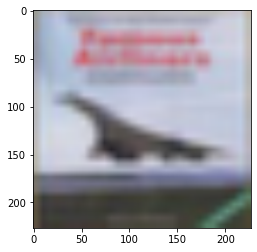

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(13, 13)


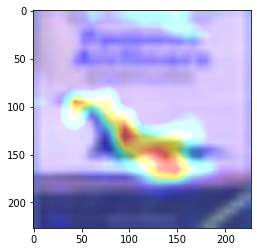

In [16]:
'''Sample an image from the test set'''

#You may change the sampling code to sample an image as you desire.
#Make sure to NOT move the sampling code to a different cell.

img_batch, labels_batch = next(iter(testloader))
img = img_batch[3]
img = img.unsqueeze(0)

# classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)
heatmap = classifier.grad_cam_on_input(img)

def visualize(img, heatmap):


    heatmap = heatmap.cpu().numpy()

    img = show_img(img)
    img = np.uint8(255 * img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    combine = 0.5 * heatmap + img

    #if not os.path.exists(write_path):
    #    os.makedirs(write_path)

    plt.imshow(combine/255)
    plt.show()


visualize(img, heatmap)

What do you observe? Show an example of an image where the method is looking at the object in question and another where it appear to be completely unrelated. In the latter case, it might have learnt a spurious correlation- aka a bias in the data which always appears to be correlated with a given label. For the ship class, this **might** be the surrounding water or for a **horse** it might be the surrounding grass. In such cases, do you think the model would predict correctly for a ship on sand or a horse in the air? Answer in a text snippet below. **Causally trained neural networks** (https://www.cmu.edu/dietrich/causality/neurips20ws/) are an exciting direction to solve this problem

***The example below shows an instance where the model is looking at the object in question.***

Predicted class was frog
Gradients shape:  torch.Size([1, 256, 13, 13])
Activations shape:  torch.Size([1, 256, 13, 13])


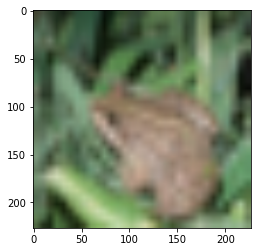

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(13, 13)


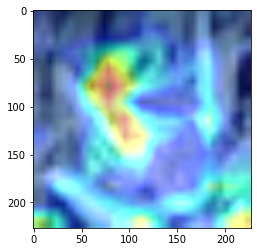

In [22]:
img_batch, labels_batch = next(iter(testloader))
img = img_batch[4]
img = img.unsqueeze(0)

# classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)
heatmap = classifier.grad_cam_on_input(img)

visualize(img, heatmap)

***The example below shows an instance where the model fails to focus on the object in question.***

1512
i =  0
Actual Class: frog
Predicted class was deer
Gradients shape:  torch.Size([1, 256, 13, 13])
Activations shape:  torch.Size([1, 256, 13, 13])


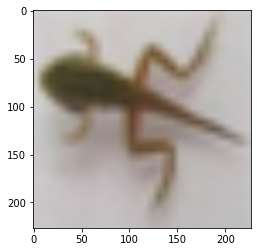

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(13, 13)


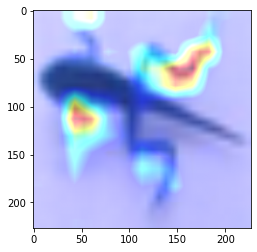

In [ ]:
# Your code here to show an failure case. 
# You can refer the steps and functions implemented in the previous cell and reuse them.
# img_batch, labels_batch = next(iter(testloader))
print(len(classifier.batch_idx))
for idx, data in enumerate(testloader):
  if idx in classifier.batch_idx:
    # i = 1
    i = classifier.batch_idx.index(idx)
    print("i = ", i)
    final_img = data[0]
    # print(f'Batch Number {idx}')
    print(f'Predicted Class: {class_names[classifier.wrong_label_idx[i]]}')
    print(f'Actual Class: {class_names[classifier.true_label_idx[i]]}')
    break

img = final_img[classifier.img_idx[i]]
# # img = img_batch[4]
img = img.unsqueeze(0)

# # classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)
heatmap = classifier.grad_cam_on_input(img)

visualize(img, heatmap)

**Answer**:
I stored all images where there is a discrepancy between the predicted class and the labeled class in the evaluate method and randomly selected this frog example. Using the heatmap, we can clearly see where the "focus" of our model is when it makes its decision. In the pictures above, instead of focusing on the body, the model focused on the frog's 2 legs and the water around it. It is possible that the model assumed that they are the antlers of a deer thus assigned it the label of a deer.

### Kernel and Activation Visualizations

We will visualize some learned convolutional kernels for two layers in the conv-net. Study the code provided for **trained_kernel_viz** carefully. You only have to fill out the line for **filter**. All you are expected to do is to access the relevantt layer from **self.conv_model** and set **filter** equal to its weight parameter.

Call this function on the alexnet classifier. What do you observe?

torch.Size([8, 3, 11, 11])


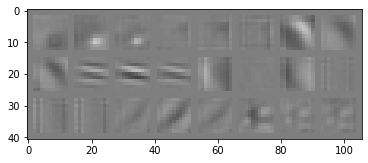

torch.Size([8, 8, 5, 5])


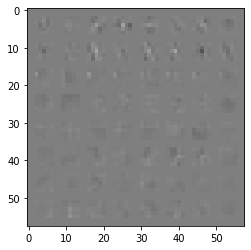

In [ ]:
classifier.trained_kernel_viz()

Now with the kernel viz filled out, write the method for activation visualizations **activations on input**. The structure for the code is very similar to the kernel viz, except that we are actually viewing the output of the model at each stage and not for the kernel at that stage. Once filled, please call this method on a few sample images. What do you observe? Answer generally in a text snippet below.

**Answer**: 
The torch size shows that the 1st convolutional layer's kernel size is 11 x 11, while the 2nd convolutional layer's kernel size is 5 x 5. The difference between the first and second layers is that the first layer detects edges, while the second layer detects shapes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


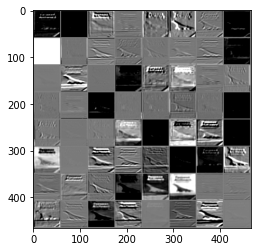

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


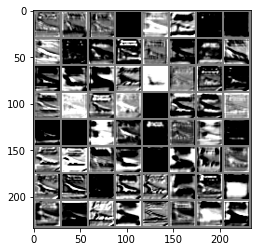

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


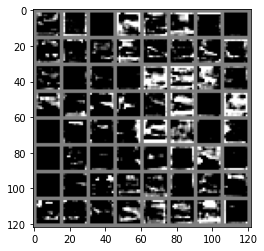

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


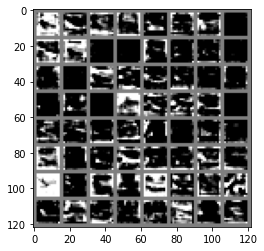

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


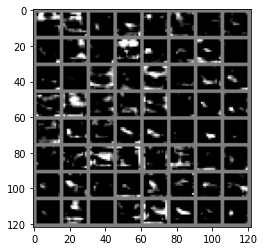

In [ ]:
'''Sample an image from the test set'''
#You may change the sampling code to sample an image as you desire.
#Make sure to NOT move the sampling code to a different cell.
img_batch, labels_batch = next(iter(testloader))
img = img_batch[3]
img = img.unsqueeze(0)

classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)
classifier.activations_on_input(img)

***Another image per question asked.***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


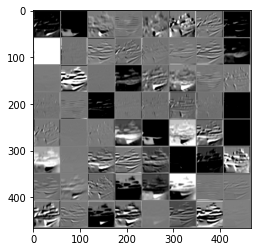

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


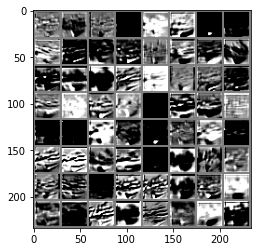

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


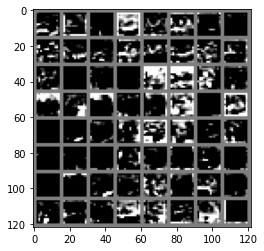

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


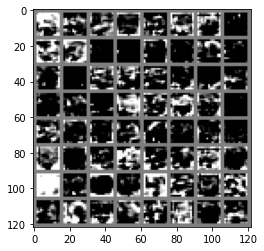

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


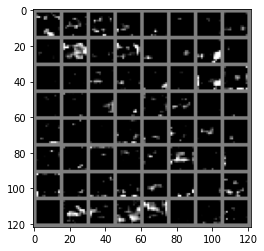

In [14]:
img_batch, labels_batch = next(iter(testloader))
img = img_batch[1]
img = img.unsqueeze(0)

classifier = Classifier(experiment_name, model, dataloaders, class_names, use_cuda=True)
classifier.activations_on_input(img)

What do you observe about early layers v. later layers? Answer in a text snippet below.

**Answer**: The first couple of layers focus on some basic features, such as edges, shapes, backgrounds etc. The latter layers, on the other hand, are able to detect and extract more meaningful features. 